In [1]:
# 12 - LONG READS
#
# This script takes the information in tagged_reads.csv and combines the reads into long reads. The script is based on 12_long_reads.ipynb
#
# INPUTS:
#   run_number
#   disease
#   tagged_reads.csv
# 
# OUTPUTS:
#   tagged_long_reads.csv

# Load modules

In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Set variables

In [3]:
run_num=3
run_number=f"run{run_num}"
chrom="chr11"
dis="sca"

# Parameters
expected_gap_fraction = 0.5

# Setup
chrom_dis=f"{chrom}_{dis}"
rootdir=f"/mnt/aretian/genomics/nanopore"
datadir=f"/mnt/aretian/genomics/nanopore/{run_number}"

In [4]:
print('')
print('----------------------------------------------------------------------')
# print(f'12 - CREATE LONG READS (__file__})')
print(f'12 - CREATE LONG READS)')
print(f"Run: {run_num}, disease: {dis}.")
print('')
print('')


----------------------------------------------------------------------
12 - CREATE LONG READS)
Run: 3, disease: sca.




# Load Data

In [5]:
df = pd.read_csv(f'{datadir}/{run_number}_{chrom}_tagged_reads.csv')
original_columns = df.columns
df = df.rename(columns={'startpos':'orig_pos'})
shift = min(df['orig_pos'])
df['pos'] = df['orig_pos'] - shift
df['seq_len']= df['read'].apply(lambda x: len(x))
df['end_pos']=df['pos']+df['seq_len']-1
df['sample'] = df['samplename'].str[-1].astype(int)

# Helper functions

## Create Bins

In [6]:
def create_bins(df):
    total_length = max(df['end_pos'])
    reads_0 = df[df['sample']==0]
    reads_1 = df[df['sample']==1]

    # Number of reads
    n_0=len(reads_0)
    n_1=len(reads_1)

    # Average length
    mean_length = df['seq_len'].mean()
    mean_length_0 = reads_0['seq_len'].mean()
    mean_length_1 = reads_1['seq_len'].mean()

    # Total bins
    expected_gap = mean_length*expected_gap_fraction
    bin_length = round(mean_length + expected_gap)
    n_bins_exact = total_length/bin_length 
    n_bins = round(n_bins_exact)

    # Bins in  person0
    n_long_reads_0 = n_0/n_bins
    # Bins in person1
    n_long_reads_1 = n_1/n_bins
    
    # Force at least 10 long_reads
    n_long_read_threshold = 10
    if n_long_reads_0<n_long_read_threshold:
        n_long_reads_0=n_long_read_threshold
        n_bins_0 = round(n_0/n_long_reads_0)
        
    if n_long_reads_1<n_long_read_threshold:
        n_long_reads_1=n_long_read_threshold
        n_bins_1 = round(n_1/n_long_reads_1)
        
    try:
        if n_bins_0 < n_bins_1:
            n_bins = n_bins_0
            bin_length = round(total_length/n_bins)
            n_bins_exact = total_length/bin_length 
            print(f"Too few reads for person0. Setting n_bins={n_bins} to get at least {n_long_read_threshold} long reads.")
        elif n_bins_0 > n_bins_1:
            n_bins = n_bins_1
            bin_length = round(total_length/n_bins)
            n_bins_exact = total_length/bin_length 
            print(f"Too few reads for person1. Setting n_bins={n_bins} to get at least {n_long_read_threshold} long reads.")
    except:
        try:
            n_bins = n_bins_0
            bin_length = round(total_length/n_bins)
            n_bins_exact = total_length/bin_length 
            print(f"Too few reads for person0. Setting n_bins={n_bins} to get at least {n_long_read_threshold} long reads.")
        except:
            try:
                n_bins = n_bins_1
                bin_length = round(total_length/n_bins)
                n_bins_exact = total_length/bin_length 
                print(f"Too few reads for person1. Setting n_bins={n_bins} to get at least {n_long_read_threshold} long reads.")
            except:
                pass
    
            
    print("")
    print(f"OPTIMAL BIN SIZE AND NUMBER")
    print("")
    print(f"Total length of region:     {total_length:,.0f}")
    print(f"Avg read length:               {mean_length:,.2f}")
    print(f"Avg read length + {expected_gap_fraction*100:,.0f}% padd:    {mean_length+expected_gap:,.2f}")
    print(f"Bin length:                    {bin_length:,.0f}")
    print(f"total_length/bin_length:           {n_bins_exact:,.2f}")
    print(f"Number of bins:                    {n_bins:,.2f} --> last bin is {'shorter' if (n_bins>n_bins_exact) else 'longer'}.")
    print("")
    print(f"ESTIMATED # OF LONG READS PER PERSON")
    print("")
    print(f"               Count       Avg Length    N of long reads (est)")
    print(f"person0        {n_0:,.0f}       {mean_length:,.0f}        {n_long_reads_0:,.0f}")   
    print(f"person1        {n_1:,.0f}       {mean_length_0:,.0f}        {n_long_reads_1:,.0f}")
    print(f"Full sample    {len(df):,.0f}       {mean_length_1:,.0f}        {n_long_reads_0 + n_long_reads_1:,.0f}")

    # Parameters
    bins = []

    last_bin_end = -1
    for i in range(int(np.floor(n_bins))):
        bin_start = last_bin_end + 1
        bin_end   = bin_start + bin_length - 1
        bins.append([bin_start, bin_end])
        last_bin_end = bin_end

    # Gap
    bin_agg_length = n_bins * bin_length
    gap = total_length - bin_agg_length
    print("")
    print(f"ADJUSTMENT FOR LAST BIN")
    print("")
    print(f"Total length:         {total_length:,.0f}")
    print(f"Bin aggregate length: {bin_agg_length:,.0f}")
    print(f"Difference:              {gap:,.0f}")

    # Last bin length
    last_bin_length = bin_length + gap
    print(f"Bin length:              {bin_length:,.0f}")
    print(f"Last bin length:         {last_bin_length:,.0f}")

    # Adjust last bin length
    bins[-1][1]=bins[-1][0]+last_bin_length-1
    
    return bins

## Assign reads to bins

In [7]:
def assign_reads_to_bins(df, bins, selected_person):
# Returns person_reads with the 'bin' column of bin membership
    
    print("")
    print(f"Selected person: person{selected_person}.")
    print("")
    print("Assigning reads to bins.")

    if   selected_person == 0:
        reads_0 = df[df['sample']==0]
        person_reads = reads_0.copy()
    elif selected_person == 1:
        reads_1 = df[df['sample']==1]
        person_reads = reads_1.copy()

    # Count empty bins
    empty_bins = 0
    empty_bins_list = []

    # Initialize bin column with empty lists
    person_reads['bin']=np.empty((len(person_reads), 0)).tolist()

    # Lambda function to append bin membership to list
    def append_bin(read, bin):
        read['bin'].append(bin)
        return read

    # Add bin membership column to person_reads df
    for n, bin in enumerate(bins):

        # Get reads in bin
        read_starts_inside = (person_reads['pos']    >bin[0]) & (person_reads['pos']    <bin[1])
        read_ends_inside   = (person_reads['end_pos']>bin[0]) & (person_reads['end_pos']<bin[1])
        read_covers        = (person_reads['pos']    <bin[0]) & (person_reads['end_pos']>bin[1])

        overlaps_bin = (read_starts_inside | read_ends_inside | read_covers)

        # Count empty bins
        if overlaps_bin.sum() == 0:
            empty_bins = empty_bins + 1
            empty_bins_list.append(n)
            continue

        # Append bin number to bin column
        person_reads.loc[overlaps_bin].apply(lambda x: append_bin(x, n), axis=1)

    print(f"Done. Reads with no assigned bin: {person_reads['bin'].isna().sum()}")
    print(f"There are {empty_bins} empty bins: {empty_bins_list}")
    
    return person_reads

## Create long reads

In [8]:
def create_long_reads(person_reads):
# Populated the person_reads dataframe with the long_read column
    
    print("")
    print("Creating long reads.")
    
    max_bin_n = max(person_reads['bin'].max())
    
    # List of bins to iterate over
    search_bins = list(range(max_bin_n+1))

    # Initialize long read membership
    person_reads['long_read'] = np.nan
    # Track reads that are already assigned
    person_reads['assigned'] = False

    long_read_number = 0

    n_unassigned = len(person_reads)
    
    while n_unassigned > 0:
        # While there are unassigned reads

        n_unassigned = len(person_reads) - person_reads['assigned'].sum()
        progress = (1-n_unassigned/len(person_reads))*100

        for n in search_bins:
        # Run bin loop assigning reads

            # Get reads in bin
            bin_reads_boolean = person_reads.apply(lambda x: n in x['bin'], axis=1)

            # If all reads in bin have been assigned, skip and ignore bin in the future
            if (bin_reads_boolean & ~person_reads['assigned']).any() == False:
                search_bins.remove(n)
                continue
                
            print(f"\rLong read: {long_read_number:3.0f}. Bin: {n:3.0f}. Unassigned: {n_unassigned:5.0f}. Progress: {progress:3.0f}%", end="", flush=True)
            
            # Get reads in bin that are not assigned
            bin_reads = person_reads.loc[bin_reads_boolean & ~person_reads['assigned']]

            # Get first read_id
            first_read_id = bin_reads['read_id'].unique()[0]
            
            # Assign first read_id (with all STRs) to long read
            person_reads.loc[person_reads['read_id']==first_read_id, 'long_read'] = long_read_number
            # Record assignment
            person_reads.loc[person_reads['read_id']==first_read_id, 'assigned'] = True
        
        # Go to the next long read
        long_read_number += 1
        
#         if long_read_number > 20:
#             break

    print("")
    print("Done.")
    
    return person_reads

## Trim long reads

In [9]:
def trim_long_reads(person0_reads, person1_reads, desired_n_long_reads, n0_extract=None, n1_extract=None, ratio='manual'):

    # Set defaults for number of reads to be created
    if ratio == 'manual':
        # Default Option 1: Set manually
        n0_extract_default = 15
        n1_extract_default = 10
    elif ratio == 'proportional':
        # Default Option 2: Proportional to read counts
        n_long_reads0 = len(person0_reads)
        n_long_reads1 = len(person1_reads)
        n_long_reads = n_long_reads0 + n_long_reads1
        share_long_reads0 = n_long_reads0/n_long_reads
        share_long_reads1 = n_long_reads1/n_long_reads
        n0_extract_default = round(share_long_reads0*desired_n_long_reads)
        n1_extract_default = desired_n_long_reads - n0_extract_default
        print(f'Proportional ratio: {n0_extract_default}, {n1_extract_default}.')
    
    if n0_extract is None:
        n0_extract = n0_extract_default
    if n1_extract is None:
        n1_extract = n1_extract_default
        
    # Raise error
    if desired_n_long_reads != n0_extract + n1_extract:
        raise ValueError(f'n0_extract and n1_extract should add up to {desired_n_long_reads}')

    # Extract reads
    extract_list0 = list(person0_reads['long_read'].value_counts().iloc[:n0_extract].index)
    extract_list1 = list(person1_reads['long_read'].value_counts().iloc[:n1_extract].index)
    person0_reads_trim = person0_reads.loc[person0_reads['long_read'].isin(extract_list0)]
    person1_reads_trim = person1_reads.loc[person1_reads['long_read'].isin(extract_list1)]
    
    return person0_reads_trim, person1_reads_trim

## Fill in gaps between long reads

In [10]:
def fill_gaps_within_person(person_reads_trim):
    
    # Get longest long_read
    longest_read_n = person_reads_trim['long_read'].value_counts().index[0]
    longest_read =   person_reads_trim.loc[person_reads_trim['long_read']==longest_read_n]
    
    # Get all STRs in longest long_read
    longest_read_strs = set(longest_read['str_id'].unique())

    # Loop prep: Get total number of long reads
    n_long_reads = person_reads_trim['long_read'].nunique()
    # Loop prep: initialize dataframe to populate
    person_reads_full_within = person_reads_trim.copy()
    
    for long_read_n in range(1,n_long_reads):

        # Get nth longest long_read
        nth_longest_read_n = person_reads_trim['long_read'].value_counts().index[long_read_n]
        nth_longest_read   = person_reads_trim.loc[person_reads_trim['long_read']==nth_longest_read_n]

        # Get all reads in nth longest long_read
        nth_longest_read_strs = set(nth_longest_read['str_id'].unique())

        # Calculate difference with longest read
        str_difference = longest_read_strs.difference(nth_longest_read_strs)

        # Get missing reads
        new_reads = longest_read.loc[longest_read['str_id'].isin(str_difference)].copy()
        new_reads['long_read'] = nth_longest_read_n

        # Add to dataframe
        person_reads_full_within = pd.concat([person_reads_full_within, new_reads])
    
    return person_reads_full_within

## Plot Long reads

In [11]:
def plot_long_reads(person_reads):
    
    print("Drawing points in long reads.")
    
    # Loop prep: Get list and number of long reads
    long_reads_list = list(person_reads['long_read'].unique())
    n_long_reads = int(person_reads['long_read'].nunique())
    long_read_counter = 1

    # Loop prep: Initialize long read collection
    long_read_collection = []

    # Loop prep: Calculate total_length
    total_length = max(person_reads['end_pos'])
    
    for long_read_n in long_reads_list:
        
        long_read_binary = []

        print(f"\rProcessing long read: {long_read_counter} of {n_long_reads}", end="", flush=True)

        selected_long = person_reads.loc[person_reads['long_read']==long_read_n].copy()

        for point in range(0,total_length+1,10000):
            after_start =  selected_long['pos']< point
            before_end  =  point < selected_long['end_pos']
            is_in_read  = (after_start & before_end).any()

            value_to_append = 1 if is_in_read else np.nan
            long_read_binary.append(value_to_append)

        long_read_collection.append(long_read_binary)
        
        long_read_counter += 1


    print("")
    print("Plotting.")

    plt.subplots(figsize=(20,10))
    x = range(len(long_read_collection[0]))

    for i in range(len(long_read_collection)):
        long_read_binary = [x * (i+1) for x in long_read_collection[i]]
        plt.scatter(x, long_read_binary)

# Implementation

## Create Bins

In [12]:
bins = create_bins(df)

Too few reads for person1. Setting n_bins=12 to get at least 10 long reads.

OPTIMAL BIN SIZE AND NUMBER

Total length of region:     3,941,766
Avg read length:               26,282.75
Avg read length + 50% padd:    39,424.12
Bin length:                    328,480
total_length/bin_length:           12.00
Number of bins:                    12.00 --> last bin is longer.

ESTIMATED # OF LONG READS PER PERSON

               Count       Avg Length    N of long reads (est)
person0        337       26,283        10
person1        119       29,148        10
Full sample    456       18,169        20

ADJUSTMENT FOR LAST BIN

Total length:         3,941,766
Bin aggregate length: 3,941,760
Difference:              6
Bin length:              328,480
Last bin length:         328,486


## Assign reads to bins and create long reads

In [13]:
selected_person = 0
person0_reads = assign_reads_to_bins(df, bins, selected_person)
person0_reads = create_long_reads(person0_reads)

selected_person = 1
person1_reads = assign_reads_to_bins(df, bins, selected_person)
person1_reads = create_long_reads(person1_reads)

print("")
print(f"Person 0 long reads: {person0_reads['long_read'].max():,.0f}")
print(f"Person 1 long reads: {person1_reads['long_read'].max():,.0f}")


Selected person: person0.

Assigning reads to bins.
Done. Reads with no assigned bin: 0
There are 0 empty bins: []

Creating long reads.
Long read:  17. Bin:   1. Unassigned:     2. Progress:  99%
Done.

Selected person: person1.

Assigning reads to bins.
Done. Reads with no assigned bin: 0
There are 0 empty bins: []

Creating long reads.
Long read:  12. Bin:  11. Unassigned:     1. Progress:  99%
Done.

Person 0 long reads: 17
Person 1 long reads: 12


## Trim Long Reads

In [14]:
# person0_reads_trim, person1_reads_trim = trim_long_reads(person0_reads, person1_reads, 25, 15, 10)
person0_reads_trim, person1_reads_trim = trim_long_reads(person0_reads, person1_reads, 25, ratio='proportional')

Proportional ratio: 18, 7.


## Fill gaps within person

In [15]:
person0_reads_full_within = fill_gaps_within_person(person0_reads_trim)
person1_reads_full_within = fill_gaps_within_person(person1_reads_trim)

## Fill gaps between mother and child

2. In the difference between 1100 and 700

    Child --> ALT
    
    Mother --> REF

## Concatenate output

In [16]:
person_reads = pd.concat([person0_reads_full_within, person1_reads_full_within])

## Plot

Drawing points in long reads.
Processing long read: 18 of 18
Plotting.


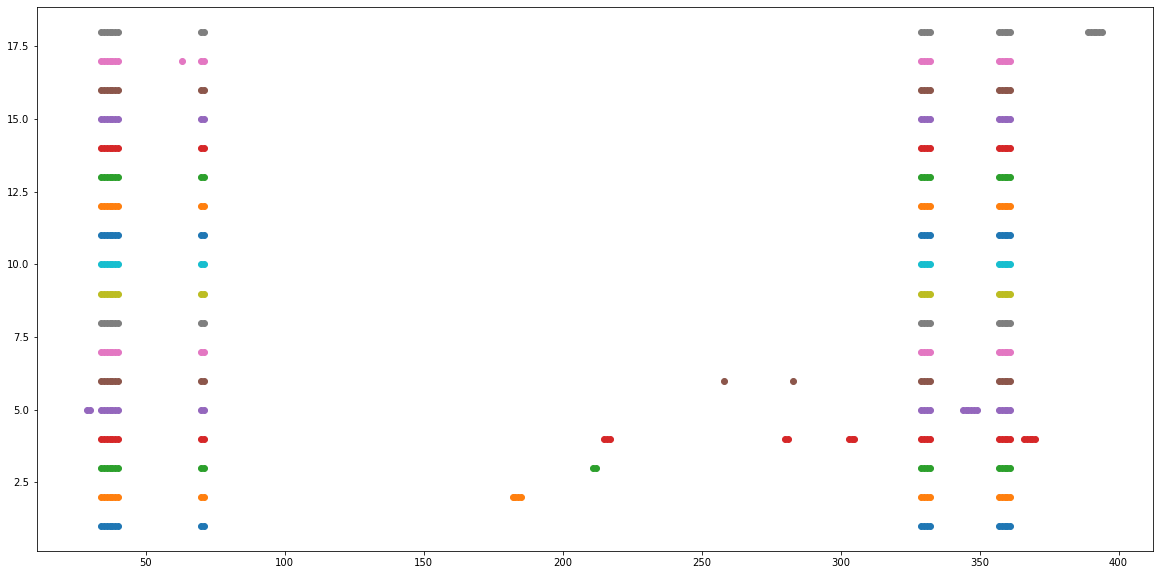

In [17]:
plot_long_reads(person0_reads_full_within)
# plot_long_reads(person0_reads)

Drawing points in long reads.
Processing long read: 7 of 7
Plotting.


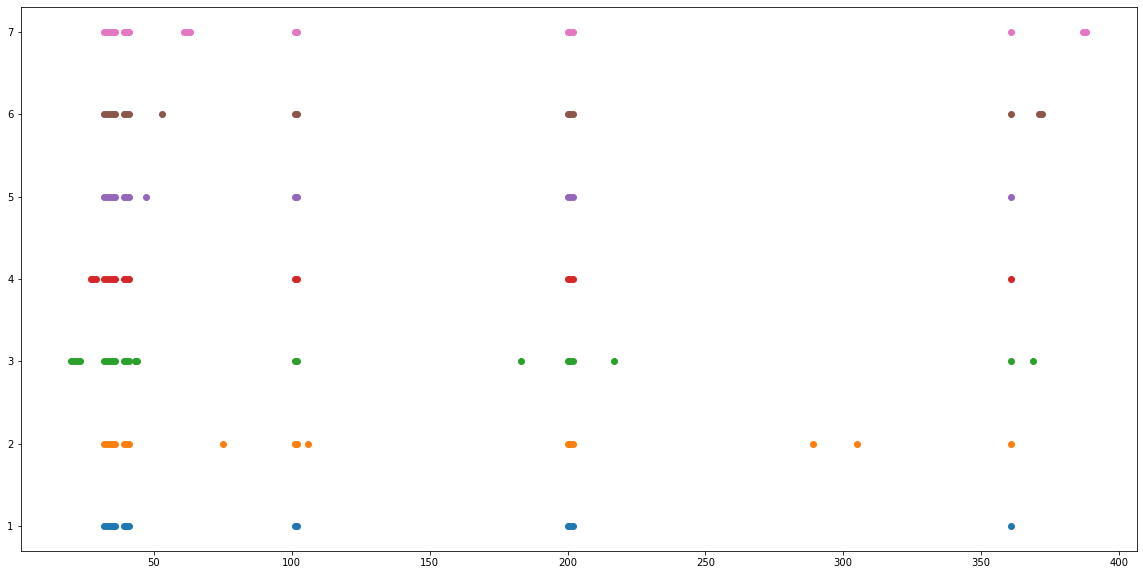

In [18]:
plot_long_reads(person1_reads_full_within)
# plot_long_reads(person1_reads)

# Create output file

In [19]:
# Rename and keep columns as original file
person_reads_out = person_reads.copy()

# Create long read ID
person_reads_out['long_read_id'] = person_reads_out['samplename'] + '-' + person_reads_out['long_read'].astype(int).astype(str)

# Replace new read ID
person_reads_out = person_reads_out.drop(columns=['read_id'])
person_reads_out = person_reads_out.rename(columns={'long_read_id':'read_id'})

# Rename columns as original
person_reads_out = person_reads_out.rename(columns={'orig_pos':'startpos'})
person_reads_out = person_reads_out[original_columns]

## Save

In [20]:
person_reads_out.to_csv(f'{datadir}/{run_number}_{chrom}_long_tagged_reads.csv', index=None)

# EXTRA CODE

# Edit Boolean Matrix

In [21]:
# # # Read file
# filename='run1_chr11_bool_tagged_reads.csv'
# mydf = pd.read_csv(f'{datadir}/{filename}')
# import subprocess

# # Create matrix to append
# mydf_append=1-mydf.iloc[:,1:]

# mydf_append.columns = mydf_append.columns+'-ALT'

# # Add columns in right order
# mydf_out = pd.DataFrame(mydf.iloc[:,0])
# for i in range(mydf_append.shape[1]):
#     mydf_out = pd.concat([mydf_out, mydf.iloc[:,i+1]], axis=1)
#     mydf_out = pd.concat([mydf_out, mydf_append.iloc[:,i]], axis=1)

# # Save
# mydf_out.to_csv(f'{datadir}/{filename}')